# 02 - PCA and Logistic Regression – From Scratch
This notebook implements Principal Component Analysis (PCA) and Logistic Regression from scratch to analyze the performance of manual and scikit-learn implementations on the infant audio dataset.

## Environment Setup and Imports

In [1]:
# Import required libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing and modeling tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

## Mount Google Drive

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Extracted Features and Labels

In [3]:
# Load processed features and labels from CSV file
csv_path = '/content/drive/MyDrive/features_with_labels.csv'
df_features = pd.read_csv(csv_path)

# Separate features and target labels
X_features = df_features.drop(columns=['Label']).values
y = df_features['Label'].values

print(f"Loaded X_features shape: {X_features.shape}")
print(f"Loaded y shape: {y.shape}")

Loaded X_features shape: (324, 9)
Loaded y shape: (324,)


## Baseline Logistic Regression (Before Scaling and PCA)

In [4]:
# Baseline model without feature scaling or dimensionality reduction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import time

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

# Train baseline Logistic Regression
print("\n--- Baseline Logistic Regression BEFORE Scaling and PCA ---")
start = time.time()
lr_baseline = LogisticRegression(random_state=42, max_iter=2000, n_jobs=-1)
lr_baseline.fit(X_train, y_train)
acc_baseline = lr_baseline.score(X_test, y_test)
elapsed = time.time() - start

print(f"Accuracy: {acc_baseline:.4f}, Training time: {elapsed:.2f}s")


--- Baseline Logistic Regression BEFORE Scaling and PCA ---
Accuracy: 0.8308, Training time: 2.45s


## Feature Scaling

In [5]:
# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

## Step 1 – Logistic Regression (Scaled Features, No PCA)

In [6]:
# Logistic Regression using scaled features (no PCA)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("--- Step 1: Sklearn Logistic Regression without PCA ---")
start = time.time()
lr_sklearn = LogisticRegression(random_state=42, max_iter=2000, n_jobs=-1)
lr_sklearn.fit(X_train, y_train)
acc = lr_sklearn.score(X_test, y_test)
print(f"Accuracy: {acc:.4f}, Training time: {time.time()-start:.2f}s")

--- Step 1: Sklearn Logistic Regression without PCA ---
Accuracy: 0.9538, Training time: 0.91s


## Step 2 – Manual Implementation of Logistic Regression

In [7]:
def manual_logistic_regression(X_train, y_train, X_test, y_test, lr=0.1, epochs=500):
    """
    Train manual logistic regression using softmax and cross-entropy loss.
    Returns weights, bias, accuracy, and loss history.
    """
    num_classes = len(np.unique(y_train))
    y_train_onehot = np.eye(num_classes)[y_train]

    num_features = X_train.shape[1]
    W = np.zeros((num_features, num_classes))
    b = np.zeros((1, num_classes))

    # Softmax function
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # Cross-entropy loss
    def cross_entropy(y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-15), axis=1))

    loss_history = []
    for epoch in range(epochs):
        logits = X_train @ W + b
        y_pred = softmax(logits)
        loss = cross_entropy(y_train_onehot, y_pred)
        loss_history.append(loss)

        # Gradient computation
        grad_W = (X_train.T @ (y_pred - y_train_onehot)) / X_train.shape[0]
        grad_b = np.mean(y_pred - y_train_onehot, axis=0, keepdims=True)

        # Parameter update
        W -= lr * grad_W
        b -= lr * grad_b

    # Evaluation on test data
    logits_test = X_test @ W + b
    y_test_pred = np.argmax(softmax(logits_test), axis=1)
    acc = np.mean(y_test_pred == y_test)

    return W, b, acc, loss_history

## Step 2 – Manual Logistic Regression (Scaled Features, No PCA)

--- Step 2: Manual Logistic Regression without PCA ---
Accuracy: 0.9538, Training time: 0.06s


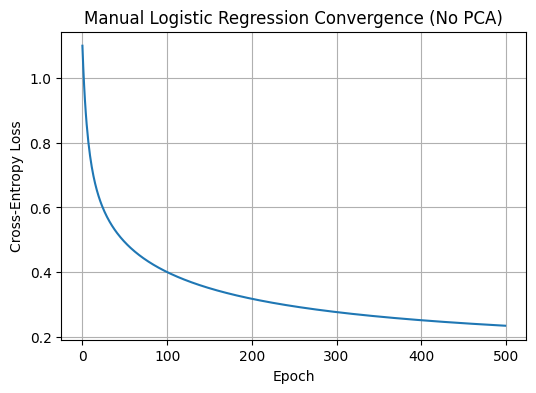

In [8]:
# Manual Logistic Regression without PCA (with timing)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Parameters
lr_manual = 0.1
epochs = 500

# Train and measure execution time
print("--- Step 2: Manual Logistic Regression without PCA ---")
start = time.time()
W, b, acc_manual, loss_history = manual_logistic_regression(
    X_train, y_train, X_test, y_test,
    lr=lr_manual,
    epochs=epochs
)
elapsed = time.time() - start

print(f"Accuracy: {acc_manual:.4f}, Training time: {elapsed:.2f}s")

# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Manual Logistic Regression Convergence (No PCA)")
plt.grid(True)
plt.show()

## Step 3 – Logistic Regression with PCA (Sklearn Implementation)

In [9]:
# Logistic Regression using PCA-transformed features (Sklearn PCA)

# Apply PCA preserving 99% variance
pca_sklearn = PCA(n_components=0.99, random_state=42)
X_pca_sklearn = pca_sklearn.fit_transform(X_scaled)

# Split PCA-transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_sklearn, y, test_size=0.2, random_state=42
)

print("--- Step 3: Sklearn Logistic Regression with Sklearn PCA ---")
start = time.time()
lr_sklearn_pca = LogisticRegression(random_state=42, max_iter=2000, n_jobs=-1)
lr_sklearn_pca.fit(X_train_pca, y_train_pca)
acc_pca_sklearn = lr_sklearn_pca.score(X_test_pca, y_test_pca)
print(f"Accuracy: {acc_pca_sklearn:.4f}, Training time: {time.time()-start:.2f}s")

--- Step 3: Sklearn Logistic Regression with Sklearn PCA ---
Accuracy: 0.9692, Training time: 0.01s


## Step 4 – Manual PCA Implementation

In [10]:
def manual_pca(X, n_components=None, var_ratio=0.99):
    """
    Manual PCA using covariance matrix and eigen decomposition.
    If n_components is None, selects enough components to preserve var_ratio of variance.
    Returns projected data, eigenvectors, and number of components.
    """
    X = np.array(X)
    X_centered = X - X.mean(axis=0)
    cov_matrix = np.cov(X_centered.T)

    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]

    # Determine number of components to retain
    if n_components is None:
        explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
        cum_variance = np.cumsum(explained_variance_ratio)
        n_components = np.searchsorted(cum_variance, var_ratio) + 1

    # Project data onto selected principal components
    X_pca = X_centered @ eigenvectors[:, :n_components]
    return X_pca, eigenvectors[:, :n_components], n_components

## Step 5 – Manual PCA + Manual Logistic Regression

Shape after manual PCA: (324, 8), n_components=8
Manual Logistic Regression Accuracy (Manual PCA): 0.9538, Training time: 0.06s


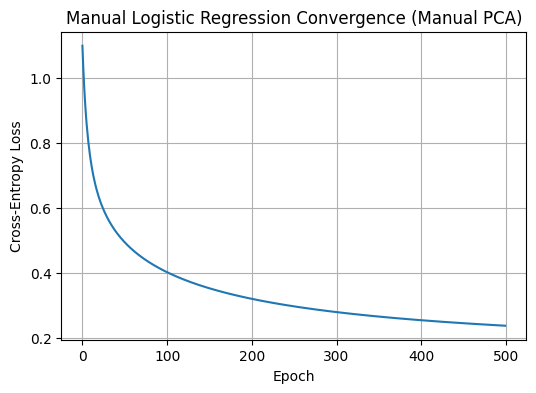

In [11]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Apply manual PCA
X_pca_manual, _, n_components = manual_pca(X_scaled, var_ratio=0.99)

# Train-test split
X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(
    X_pca_manual, y, test_size=0.2, random_state=42
)

# Train manual logistic regression on PCA-transformed data
start = time.time()
W_manual, b_manual, acc_manual_pca, loss_history_manual = manual_logistic_regression(
    X_train_manual, y_train_manual, X_test_manual, y_test_manual,
    lr=0.1, epochs=500
)
elapsed = time.time() - start

print(f"Shape after manual PCA: {X_pca_manual.shape}, n_components={n_components}")
print(f"Manual Logistic Regression Accuracy (Manual PCA): {acc_manual_pca:.4f}, Training time: {elapsed:.2f}s")

# Plot training convergence
plt.figure(figsize=(6, 4))
plt.plot(loss_history_manual)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Manual Logistic Regression Convergence (Manual PCA)")
plt.grid(True)
plt.show()

## Step 6 – Accuracy vs. Number of Principal Components

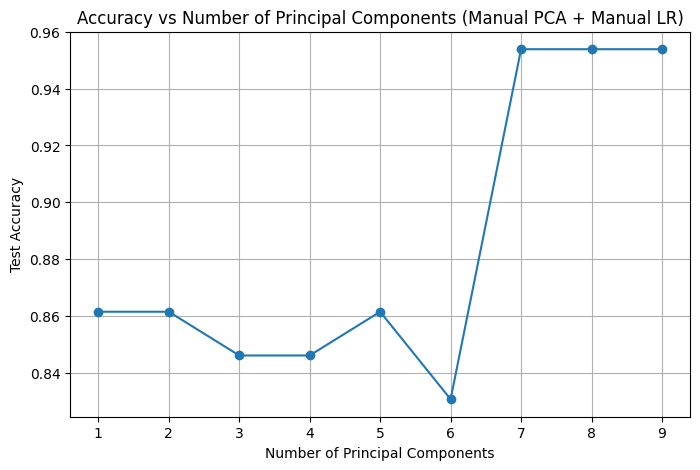

In [12]:
# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Track model accuracy for varying PCA dimensions
accuracies = []

for n_pc in range(1, X_scaled.shape[1] + 1):
    # Apply manual PCA
    X_pca_manual, _, _ = manual_pca(X_scaled, n_components=n_pc)

    # Split dataset
    X_train_manual, X_test_manual, y_train_manual, y_test_manual = train_test_split(
        X_pca_manual, y, test_size=0.2, random_state=42
    )

    # Train manual logistic regression
    _, _, acc_manual, _ = manual_logistic_regression(
        X_train_manual, y_train_manual, X_test_manual, y_test_manual,
        lr=0.1, epochs=500
    )

    accuracies.append(acc_manual)

# Plot accuracy trend
plt.figure(figsize=(8, 5))
plt.plot(range(1, X_scaled.shape[1] + 1), accuracies, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Test Accuracy")
plt.title("Accuracy vs Number of Principal Components (Manual PCA + Manual LR)")
plt.grid(True)
plt.show()